import modules

In [10]:
# @title import modules
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import imageio
from IPython.display import Image
from IPython import display
import time
from typing import Tuple, List
from model import model
from likelihoods import spread_likelihood, transition_likelihood, total_likelihood
from risk_conv import risk_convolution2D

# Gradient-based learning of $\beta$ using the likelihood of the transitions

## Finding the likelihood of a transition

Through a series of differentiable transformations, we can calculate the total likelihood of transitioning from a given input state $x_t$ to an output state $x_{t+1}$, for a given $\beta$ value. In the following, a quick overview of the transformations is provided using an example transition:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix},
\beta = 0.1
$$

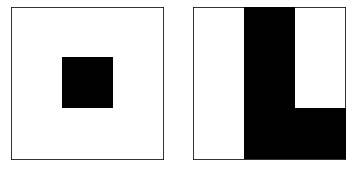

In [8]:
# Define the two grids
x_t = t.zeros((1,3,3))
x_t[0,1,1] = 1
x_tt = t.zeros((1,3,3))
x_tt[0,1,1] = 1.
x_tt[0,2,1] = 1.
x_tt[0,2,2] = 1.
x_tt[0,0,1] = 1.

# Visualize the grids
fig, axs = plt.subplots(1,2)
axs[0].imshow(x_t[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[1].imshow(x_tt[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)

### 1. Get the amount of active neighbors for each cell in $x_t$

$$
Y= \begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast x_t
$$

In [11]:
risk_convolution2D(x_t)

tensor([[[[1., 1., 1.],
          [1., 0., 1.],
          [1., 1., 1.]]]])

### 2. Determine the likelihood of spread for each cell in $x_t$ based on the number of active neighbors and $\beta$

$$
L = \begin{pmatrix}
1-(1-\beta)^{Y_{11}} & \dots & 1-(1-\beta)^{Y_{k1}} \\
\dots & \dots & \dots \\
1-(1-\beta)^{Y_{1k}} & \dots & 1-(1-\beta)^{Y_{kk}} 
\end{pmatrix}
$$

NOTE: Here, we do not take into account the current state of the cells in $x_t$ yet.

In [13]:
L = spread_likelihood(x_t, t.tensor(0.1))
print(L)

tensor([[[0.1000, 0.1000, 0.1000],
         [0.1000, 0.0000, 0.1000],
         [0.1000, 0.1000, 0.1000]]])


### 3. Account for the input state of the cells in $x_t$ and the output state of the cells in $x_{t+1}$

There are three cases to consider. Cells can transition from:

- **A:** state 0 to state 1, e.g. cell $(0,1)$. The probability of this transition is given by $L_{01}$
- **B:** state 0 to state 0, e.g. cell $(0,0)$. The probanility of this transition is given by $(1-L_{00})$
- **C:** state 1 to state 0, e.g. cell $(1,1)$. The probability of this is 1 by construction

To capture this in a single function, we use:

$$P = (1 - x_t) \odot (1 - x_{t+1}) \odot (1 - L) + (x_{t+1} \odot L \odot (1 - x_t)) + x_t$$

where $\odot$ stands for element-wise multiplication.

The function can be broken down into three pieces that get added up:

1. $(1 - x_t) \odot (1 - x_{t+1}) \odot (1 - L)$:

This covers scenario **B**. If a cell is active at either $t$ or $t+1$, this evaluates to $0$.

2. $(x_{t+1} \odot L \odot (1 - x_t))$

This covers scenario **A**. If a cell $ij$ is inactive at time $t$ and becomes active at $t+1$, it evaluates to $L_{ij}$, else 0.

3. $x_t$:

This covers scenario **C**. If a cell was already active at time $t$, this evaluates to 1

In [15]:
P = transition_likelihood(L, x_t, x_tt)
print(P)

tensor([[[0.9000, 0.1000, 0.9000],
         [0.9000, 1.0000, 0.9000],
         [0.9000, 0.1000, 0.1000]]])


### 4. Determine the total likelihood

$P$ gives us a matrix where each entry $ij$ corresponds to the likelihood of transitioning from $x_t^{ij}$ to $x_{t+1}^{ij}$ given beta. To get the total likelihood of the transition, we need to calculate the product of all entries. For our example, this likelihood should come out to $\approx 0.0006$

In [17]:
likelihood = total_likelihood(P)
print(likelihood)

tensor(0.0006)


## Working out the learning method for single samples


**Objective:** Find the parameter $\beta$ that maximizes the likelihood of the sample transition

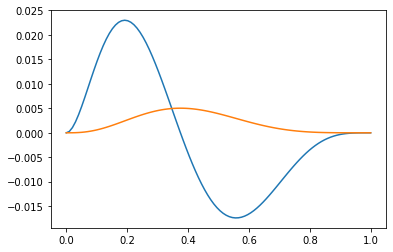

In [3]:
x_t = t.zeros((1,3,3))
x_t[0,1,1] = 1
x_tt = t.zeros((1,3,3))
x_tt[0,1,1] = 1.
x_tt[0,2,1] = 1.
x_tt[0,2,2] = 1.
x_tt[0,0,1] = 1.


betas = t.linspace(0,1,100)
gradients = []
tot_likelihoods = []
for beta in betas:
    beta.requires_grad_()
    l = spread_likelihood(x_t, beta)
    p = transition_likelihood(l, x_t, x_tt)
    tot_likelihood = total_likelihood(p)
    gradient = t.autograd.grad(tot_likelihood, beta)[0]
    gradients.append(gradient.detach().numpy())
    tot_likelihoods.append(tot_likelihood.detach().numpy())

plt.plot(betas, gradients, label="grd w.r.t. p")
plt.plot(betas, tot_likelihoods, label="likelihood")


**Exercise 1**: If we try to estimate beta for a single transition sample 

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

We can work out the solution analytically. Every cell around the seed has 1 neighbor, reducing the probability for activation to $1-(1-\beta)^1=\beta$. This means, that every cell transitions with probability $\beta$ from inactive to active. In our example, 3 out of 8 cells transition to the active state. This is equivalent to stating that out of 8 independent bernoull trials, 3 were successful. The maximum likelihood estimate for $\beta$ is hence $\frac{3}{8}=0.375$. 

We can show, that the gradient-based method does converge towards this value:

In [ ]:
# @title finding beta based on the gradients
x_t = jnp.zeros((1,3,3))
x_t = x_t.at[0,1,1].set(1)
x_tt = jnp.zeros((1,3,3))
x_tt = x_tt.at[0,1,1].set(1)
x_tt = x_tt.at[0,2,1].set(1)
x_tt = x_tt.at[0,2,2].set(1)
x_tt = x_tt.at[0,0,1].set(1)

beta = 0.5

for i in range(50):
  #print(f"Gradient {grad(total_likelihood, argnums=2)(x_t,x_tt,beta)}")
  beta = beta + grad(total_likelihood, argnums=2)(x_t,x_tt,beta)
  #print(f"updated beta: {beta}")
print(f"Final Beta: {beta}")

Final Beta: 0.3750137388706207


**Exercise 2:** We consider a more complex example:
$$
x_t = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
1 & 1 & 0 \\
1 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

The risk convolution $Y$ here is given as:

$$Y = 
\begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast x
=
\begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast 
\begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 
\end{pmatrix}
= 
\begin{pmatrix}
3 & 2 & 3 \\
3 & 2 & 3 \\
3 & 2 & 3 
\end{pmatrix}
$$

It follows, that the risk matrix is given by:

$$
L = 
\begin{pmatrix}
3 & 2 & 3 \\
3 & 2 & 3 \\
3 & 2 & 3 
\end{pmatrix}
$$

The probability of cells [$x_{11}, x_{21}, x_{31}, x_{13}, x_{23}, x_{33}$] transitioning is thus respectively given by: $1-(1-\beta)^3$

$$
1-(1-\beta)^3
$$
$$
= 1- 1 - 3 \beta + 3 \beta^2 - \beta^3
$$
$$
= -3\beta+3\beta^2-\beta^3
$$

Three out of the six trials are successful, giving us an empirical probability of $0.5$. It follows that:

$$
0.5 = -3\beta+3\beta^2-\beta^3 \approx 0.206299
$$

We can again show, that the gradient-based approach converges to this value for beta:

In [ ]:
# @title finding beta based on the gradients
x_t = jnp.zeros((1,3,3))
x_t = x_t.at[0,:,1].set(1)
print(x_t)
x_tt = jnp.zeros((1,3,3))
x_tt = x_tt.at[0,:,1].set(1)
x_tt = x_tt.at[0,0,0].set(1)
x_tt = x_tt.at[0,1,0].set(1)
x_tt = x_tt.at[0,2,2].set(1)
print(x_tt)
calculate_spread_likelihood(x_t, 0.1)
p = P(x_t, x_tt, 0.1)
print(p)

def update(x_t, x_tt, beta, lr=0.01):
  return beta + lr * grad(total_likelihood, argnums=2)(x_t,x_tt,beta)

def train(x_t, x_tt, beta, lr=0.01, num_steps=1000, verbose=False):
  for i in range(num_steps):
    beta = update(x_t,x_tt,beta)
    if verbose and i % 10 == 0:
      print(f"beta after step {i}: {beta}")
  return beta

betas = np.linspace(0.01,1,20)
print(betas)
for beta in betas:
  print(f"------------\nstarting with beta: {beta}")
  final_beta = train(x_t, x_tt, beta)
  print(f"beta after 1000 gradient steps: {final_beta}")

**Exercise 3:** We consider another example transition of the form:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0\\
0 & 1 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 0\\
0 & 1 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

applying a periodic Torus padding to $x_t$ gives us the following $7\times7$ matrix:

$$
\left[\begin{array}{c|ccccc|c} 
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\hline
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\hline
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right]
$$

We get a risk matrix L of:

$$
L = 
\begin{pmatrix}
1 & 1 & 0 & 0 & 1 \\
1 & 3 & 2 & 1 & 1 \\
2 & 2 & 1 & 1 & 1\\
1 & 2 & 2 & 1 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

We find 11 entries with one active neighbor, respectively. Two of these are active themselves, removing them from consideration. Hence, it remains that we have 9 bernoulli trials with probability $\beta$, of which 2 is successful.

Further, we find 5 entries with two active neighbors, respectively. One of them is active at time $t$, leaving us with 4 bernoulli trials of probability $\beta^2-2\beta$. Out of these, 3 were successful.

Finally, there is one successful trial with 3 active neighbors.

We can write the total likelihood of this event as a bernoulli chain of form:

$$
\beta^2(1-\beta)^7(1-(1-\beta)^2)^3(1-\beta)^2(1-(1-\beta)^3)
$$

We can now use the gradient-based to find the beta, for which this transition is maximally likely, by setting:

$$
\frac{\partial}{\partial \beta}[\beta^2(1-\beta)^7(1-(1-\beta)^2)^3(1-\beta)^2(1-(1-\beta)^3)]=0
$$

We expect our approach to converge towards $\beta \approx 0.35519$


In [ ]:
# @title finding beta based on the gradients
x_t = jnp.zeros((1,5,5))
x_t = x_t.at[0,2,2].set(1)
x_t = x_t.at[0,2,1].set(1)
x_t = x_t.at[0,1,0].set(1)
print(x_t)
print("-----------------")
x_tt = jnp.zeros((1,5,5))
x_tt = x_tt.at[0,0,0].set(1)
x_tt = x_tt.at[0,1,1].set(1)
x_tt = x_tt.at[0,2,2].set(1)
x_tt = x_tt.at[0,1,2].set(1)
x_tt = x_tt.at[0,2,1].set(1)
x_tt = x_tt.at[0,2,0].set(1)
x_tt = x_tt.at[0,1,2].set(1)
x_tt = x_tt.at[0,1,0].set(1)
x_tt = x_tt.at[0,3,1].set(1)
x_tt = x_tt.at[0,3,3].set(1)
print(x_tt)
print("-------------------")
print(periodic_padding(x_t))
print("-------------------")
print(risk_convolution2D(x_t))
print("-------------------")
print(calculate_spread_likelihood(x_t, 0.1))
print("-------------------")
p = P(x_t, x_tt, 0.1)
print(p)

def update(x_t, x_tt, beta, lr=0.01):
  return beta + lr * grad(total_likelihood, argnums=2)(x_t,x_tt,beta)

def train(x_t, x_tt, beta, lr=0.01, num_steps=1000, verbose=False):
  for i in range(num_steps):
    beta = update(x_t,x_tt,beta, lr)
    if verbose and i % 100 == 0:
      print(f"beta after step {i}: {beta}")
  return beta

beta = 0.2

result = train(x_t, x_tt, beta, num_steps=3_000, lr=0.1, verbose=True)
print(f"beta after optimization: {result}")

[[[0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
-----------------
[[[1. 0. 0. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [0. 1. 0. 1. 0.]
  [0. 0. 0. 0. 0.]]]
-------------------
[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 1.]
  [0. 0. 1. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]
-------------------
[[[[1. 1. 0. 0. 1.]
   [1. 3. 2. 1. 1.]
   [2. 2. 1. 1. 1.]
   [1. 2. 2. 1. 0.]
   [0. 0. 0. 0. 0.]]]]
-------------------
[[[0.10000002 0.10000002 0.         0.         0.10000002]
  [0.10000002 0.27100003 0.19000006 0.10000002 0.10000002]
  [0.19000006 0.19000006 0.10000002 0.10000002 0.10000002]
  [0.10000002 0.19000006 0.19000006 0.10000002 0.        ]
  [0.         0.         0.         0.         0.        ]]]
-------------------
[[[0.10000002 0.9        1.         1.         0.9       ]
  [1.         0.27100003 0.19000006 0.9        0.9       ]
  [0.19000006

## Working out the method for a dataset of state transitions, sampled with the same $\beta$

optimize the sum of the log likelihoods of the samples.

In [ ]:
# @title defining hyperparameters

grid_size = 9 #@param {type:"number"}
w=h=grid_size
beta = 0.08 #@param {type:"slider", min:0, max:1, step:0.01}
num_sequences = 100 # @param {type:"number"}
steps_per_sequence = 20
sequences = np.zeros((num_sequences, steps_per_sequence, h, w))

(1900, 2, 9, 9)


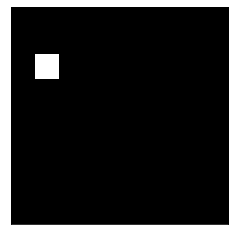

In [ ]:
# @title generate dataset
batch = News_Spread_PCA(w,h,1,num_sequences,beta)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch.grids[:,:,:,-1]
  batch.evolve()
np.save("./sequence_data", sequences)
visualize_sequence(sequences[np.random.randint(0,num_sequences)], framerate=0.1)
dataset = chop_and_shuffle_data(sequences)
np.save("./dataset", dataset)
print(dataset.shape)

In [ ]:
# @title define helper functions

def neg_log_likelihood(x_t:np.ndarray, x_tt:np.ndarray, beta:float) -> float:
  """
  Calculate the negative log-likelihood of the dataset.
  """
  return - jnp.sum(jnp.log(P(x_t,x_tt,beta)))

def update(x_t:np.ndarray, x_tt:np.ndarray, beta:float, derivative_fn, lr=0.01) -> Tuple[float, float]:
  """
  Execute one step into the direction of the negative gradient (Gradient descent),
  scaled by the learning rate.
  """
  step = lr * derivative_fn(x_t,x_tt,beta)
  updated = beta - step
  return updated, step

def train(x_t:np.ndarray, x_tt:np.ndarray, beta:float, derivative_fn, lr=0.01, num_steps=1000, verbose=False) -> Tuple[float, List[float], List[float], List[float]]:
  """
  Execute the training loop.
  """
  betas = []
  grad_steps = []
  losses = []
  for i in range(num_steps):
    beta, step = update(x_t,x_tt,beta, derivative_fn, lr)
    losses.append(neg_log_likelihood(x_t, x_tt, beta))
    betas.append(beta)
    grad_steps.append(step)
    if verbose and i % 100 == 0:
      print(f"beta after step {i}: {beta}")
  return beta, betas, grad_steps, losses

starting with beta=0.5488135039273248
148.28613
Final Beta: 0.07797738164663315


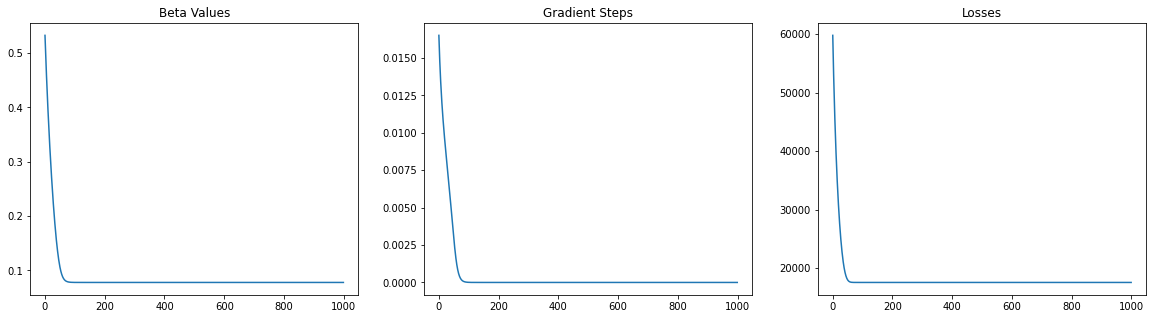

In [ ]:
# @title Find beta
np.random.seed(0)
beta = np.random.random()
x_t = dataset[:,0,:,:]
x_tt = dataset[:,1,:,:]

print(f"starting with beta={beta}")

derivative_fn = grad(neg_log_likelihood, argnums=2)

#print(x_t[0])
#print("----------------------")
#print(x_tt[0])
#print("----------------------\n Transition Probability Matrix:\n")
#print(P(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0),beta))
#print("----------------------\n negative log likelihood Matrix:\n")
#print(-jnp.log(P(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0),beta)))
#print("----------------------\n total negative log likelihood:\n")
#print(neg_log_likelihood(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0), beta))
#print("----------------------\n gradient of the negative log likelihood: \n")
#print(derivative_fn(np.expand_dims(x_t[0], axis=0), np.expand_dims(x_tt[0], axis=0), beta))

result, beta_hist, grad_steps, losses = train(x_t, x_tt, beta, derivative_fn, lr=1e-7)

fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.arange(len(beta_hist)), beta_hist, label="beta")
axs[0].set_title('Beta Values')
axs[1].plot(np.arange(len(beta_hist)), grad_steps, label="grad_steps")
axs[1].set_title('Gradient Steps')
axs[2].plot(np.arange(len(beta_hist)), losses, label="losses")
axs[2].set_title('Losses')

print(f"Final Beta: {result}")

Final Beta: 0.07797738164663315


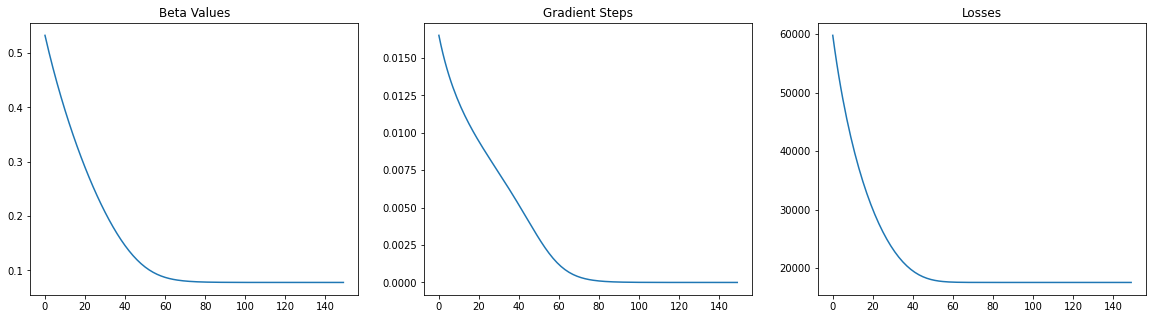

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.arange(150), beta_hist[:150], label="beta")
axs[0].set_title('Beta Values')
axs[1].plot(np.arange(150), grad_steps[:150], label="grad_steps")
axs[1].set_title('Gradient Steps')
axs[2].plot(np.arange(150), losses[:150], label="losses")
axs[2].set_title('Losses')

print(f"Final Beta: {result}")